# Challenge Data Scientist - Wen Li

The goal of this project is to predict the probability of delay of the flights that land or take off from the airport of Santiago de Chile (SCL). For that, we have a dataset using public and real data where each row corresponds to a flight that landed or took off from SCL in 2017.

## 0.0 Package Import and Global variables assignment

In [1]:
!pip install tabulate
!pip install xgboost

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.

In [2]:
import pandas as pd
import numpy as np
from tabulate import tabulate
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import plotly.express as px
from xgboost import plot_tree
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
import xgboost as xgb
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, average_precision_score, roc_auc_score

source_df = 'dataset_SCL.csv'
develop_flag = False # This could set as True if reviewer want to check some print statement 

## 1.0 Read Data

In [3]:
raw_df = pd.read_csv(source_df)
if develop_flag:
    display(raw_df.head(5))
    print('The shape of raw dataset is {}'.format(raw_df.shape))

/tmp/ipykernel_847/1113842364.py:1: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv(source_df)


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


The shape of raw dataset is (68206, 18)


## 2.0 Data Pre-processing

### 2.1 Data cleaning

In [115]:
## 2.1.1 Remove duplicate data
df = raw_df.drop_duplicates()
print('Drop {} duplicated rows'.format(raw_df.shape[0]-df.shape[0]))
## 2.1.2 Check and fix structural errors if there are any
### Convert data type
df['Fecha-I'] = pd.to_datetime(df['Fecha-I'])
df['Fecha-O'] = pd.to_datetime(df['Fecha-O'])

### Check whether the dest airport code is only point one single City
if develop_flag:
    for code in set(df['Des-O']):
        code_to_city[code] = set(df[df['Des-O']==code]['SIGLADES'])
        if set(df[df['Des-O']==code]['SIGLADES']) > 1:
            print(code, code_to_city[code]) # Nothing here

## 2.1.3 Handle missing data
if develop_flag:
    missing_col = []
    for column in df.columns:
        if df[column].isnull().values.any():
            missing_col.append(column)
    for column in missing_col:
        display(df[df[column].isna()])
        
df.loc[df['Vlo-O'].isna(),'Vlo-O'] = df[df['Vlo-O'].isna()]['Vlo-I']

Drop 0 duplicated rows


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6068,2017-01-19 11:00:00,200,SCEL,SPJC,LAW,2017-01-19 11:03:00,NaN,SCEL,SPJC,56R,19,1,2017,Jueves,I,Latin American Wings,Santiago,Lima


### 2.2 Additional columns

In [116]:
## 2.2.0 Date-I & Time_I
df['Date-I'] = df['Fecha-I'].dt.strftime('%m-%d')
df['Time-I'] = df['Fecha-I'].dt.strftime('%H:%M')

## 2.2.1 high_season: if Date-I is between Dec-15 and Mar-3, or Jul-15 and Jul-31, or Sep-11 and Sep-30, 0 otherwise.
df['high_season'] = np.where((df['Date-I'] <= '03-03') | 
                             (('06-15' <= df['Date-I']) & (df['Date-I'] <= '06-31'))
                             | (('09-11' <= df['Date-I']) & (df['Date-I'] <= '09-30')) | ('12-15' <= df['Date-I']), 1, 0)

## 2.2.2 min_diff : difference in minutes between Fecha-O and Fecha-I
df['min_diff'] = (df['Fecha-O'] - df['Fecha-I'])/np.timedelta64(1,'m')

## 2.2.3 delay_15 : 1 if min_diff > 15, 0 if not.
df['delay_15'] = np.where(df['min_diff'] > 15, 1, 0)

## 2.2.4 period_day : morning (between 5:00 and 11:59), afternoon (between 12:00 and 18:59) and night (between 19:00 and 4:59)
df['period_day'] = np.where((df['Time-I'] <= '04:59') | (df['Time-I'] >= '19:00'), 'night', '')
df.loc[(df['Time-I'] <= '11:59') & ('05:00' <= df['Time-I']), 'period_day'] = 'morning'
df.loc[(df['Time-I'] <= '18:59') & ('12:00' <= df['Time-I']), 'period_day'] = 'afternoon'

## 2.2.5 Drop Date-I & Time_I
df = df.drop(['Date-I', 'Time-I'], axis=1)

## 2.2.6 Save them to new csv files
df.to_csv('synthetic_features.csv')

## 3.0 Exploratory Data Analysis
### 3.1 Data Distribution

In [117]:
## 3.1.0 Count of (Delay) Flights and delay ratio by Scheduled time series
date_df = df.groupby([df['Fecha-I'].dt.date])[['Vlo-I']].count().reset_index().rename(columns={'Fecha-I':'Date', 'Vlo-I':'Flights'})
delay_df = df.groupby([df['Fecha-I'].dt.date])[['delay_15']].sum().reset_index().rename(columns={'Fecha-I':'Date', 'delay_15':'Delayed Flights'})
date_df = date_df.join(delay_df.set_index('Date'), how="inner", on='Date')
date_df['Delayed Ratio'] = date_df['Delayed Flights']/date_df['Flights']

fig = px.line(date_df, x='Date', y=date_df.columns, 
              title='Time Series Plot for Counts of Flights, Delayed Flights and Delayed ratio')
fig.show()

Plot.1. The Time series plot for Counts of Flights, Delayed Flights and Delayed ratio

If you want to check the plot of single variable, you can just click variable in right-top corner to optional include/remove it.
There are some outliers on high delayed ratio from this plot. We can either remove them or figure out a method to consider this. The current approach is to include average delay rate in that day.

In [118]:
## 3.1.1 Value counts for Operation Destination City
destination = pd.DataFrame(df['SIGLADES'].value_counts().sort_index(ascending=True).sort_values(ascending=False))
print(tabulate(destination, headers = ['Destination of City', 'Count of Flights'], tablefmt = 'psql'))

+-----------------------+--------------------+
| Destination of City   |   Count of Flights |
|-----------------------+--------------------|
| Buenos Aires          |               6335 |
| Antofagasta           |               5786 |
| Lima                  |               5270 |
| Calama                |               5146 |
| Puerto Montt          |               4357 |
| Concepcion            |               3993 |
| Iquique               |               3747 |
| Sao Paulo             |               3569 |
| Temuco                |               2589 |
| Arica                 |               2436 |
| La Serena             |               2410 |
| Punta Arenas          |               2105 |
| Ciudad de Panama      |               1850 |
| Copiapo               |               1780 |
| Mendoza               |               1625 |
| Bogota                |               1604 |
| Rio de Janeiro        |               1435 |
| Montevideo            |               1066 |
| Cordoba    

Table.1. The distribution of Destination City

From this table, we can check how the destination city is distributed. There are some destination 
cities which only have a few flights total.

In [119]:
## 3.1.2 Value counts for season
season = pd.DataFrame(df['high_season'].value_counts().sort_index(ascending=True).sort_values(ascending=False))
print(tabulate(season, headers = ['Is high season?', 'Count of Flights'], tablefmt = 'psql'))

+-------------------+--------------------+
|   Is high season? |   Count of Flights |
|-------------------+--------------------|
|                 0 |              46071 |
|                 1 |              22135 |
+-------------------+--------------------+


Table.2. The distribution of season

From this table, we can check how the season of flight is distributed. There are 1/3 of the flights are in high season.

In [120]:
## 3.1.3 Value counts for period_day
period_day = pd.DataFrame(df['period_day'].value_counts().sort_index(ascending=True).sort_values(ascending=False))
print(tabulate(period_day, headers = ['Period of Day', 'Count of Flights'], tablefmt = 'psql'))

+-----------------+--------------------+
| Period of Day   |   Count of Flights |
|-----------------+--------------------|
| afternoon       |              25506 |
| morning         |              25352 |
| night           |              17348 |
+-----------------+--------------------+


Table.3. The distribution of period of the day

From this table, we can check how the period of the day is distributed. The counts of afternoon flights were similar to morning flights, but they were more than night flights.

In [121]:
## 3.1.4 Value counts for Type of Flights
type_of_flight = pd.DataFrame(df['TIPOVUELO'].value_counts().sort_index(ascending=True).sort_values(ascending=False))
print(tabulate(type_of_flight, headers = ['Type of Flight','Count of Flights'], tablefmt = 'psql'))

+------------------+--------------------+
| Type of Flight   |   Count of Flights |
|------------------+--------------------|
| N                |              36966 |
| I                |              31240 |
+------------------+--------------------+


Table.4. The distribution of Type of Flights

From this table, we can check how the type of flight is distributed. The counts of national flights were slightly more than international flights.

In [122]:
## 3.1.5 Value counts for Airlines Company
airline_company = pd.DataFrame(df['OPERA'].value_counts().sort_index(ascending=True).sort_values(ascending=False))
print(tabulate(airline_company, headers = ['Airline Company','Count of Flights'], tablefmt = 'psql'))

+--------------------------+--------------------+
| Airline Company          |   Count of Flights |
|--------------------------+--------------------|
| Grupo LATAM              |              40892 |
| Sky Airline              |              14298 |
| Aerolineas Argentinas    |               1949 |
| Copa Air                 |               1850 |
| Latin American Wings     |               1674 |
| Avianca                  |               1152 |
| JetSmart SPA             |               1095 |
| Gol Trans                |                806 |
| American Airlines        |                757 |
| Air Canada               |                565 |
| Iberia                   |                362 |
| Delta Air                |                358 |
| Air France               |                358 |
| Aeromexico               |                351 |
| United Airlines          |                335 |
| Oceanair Linhas Aereas   |                279 |
| Alitalia                 |                259 |


Table.5. The distribution of Airline Company

From this table, we can check how the airline company is distributed. 

In [123]:
## 3.1.6 Value counts for Airlines Code
prog_airline = pd.DataFrame(df['Emp-I'].value_counts().sort_index(ascending=True).sort_values(ascending=False))
op_airline = pd.DataFrame(df['Emp-O'].value_counts())
airline_code = prog_airline.join(op_airline, how="inner")
print(tabulate(airline_code, headers = ['Airline Code','Count of Programmed Flights','Count of Operated Flights'], tablefmt = 'psql'))

+----------------+-------------------------------+-----------------------------+
| Airline Code   |   Count of Programmed Flights |   Count of Operated Flights |
|----------------+-------------------------------+-----------------------------|
| LAN            |                         37611 |                       20988 |
| SKU            |                         14298 |                       14298 |
| TAM            |                          3049 |                        3046 |
| ARG            |                          1949 |                        1946 |
| CMP            |                          1850 |                        1850 |
| AVA            |                          1152 |                         885 |
| JAT            |                          1095 |                        1095 |
| GLO            |                           806 |                         806 |
| AAL            |                           757 |                         757 |
| ACA            |          

Table.6. The distribution of Airline Code in programmed and operated

From this table, we can check how the programmed Airline code and operated Airline code are distributed. We can say that there are some flights that update their airline code when they do actual operations. Thus the count of program and operation are different.

In [124]:
## 3.1.7 Value counts for Destination(Airport) Code
prog_dest = pd.DataFrame(df['Des-I'].value_counts().sort_index(ascending=True).sort_values(ascending=False))
op_dest = pd.DataFrame(df['Des-O'].value_counts())
dest_code = prog_dest.join(op_dest, how="inner")
print(tabulate(dest_code, headers = ['Destination Code','Count of Programmed Flights',
                                        'Count of Operated Flights'], tablefmt = 'psql'))

+--------------------+-------------------------------+-----------------------------+
| Destination Code   |   Count of Programmed Flights |   Count of Operated Flights |
|--------------------+-------------------------------+-----------------------------|
| SCFA               |                          5787 |                        5786 |
| SPJC               |                          5270 |                        5270 |
| SCCF               |                          5145 |                        5146 |
| SCTE               |                          4357 |                        4357 |
| SCIE               |                          3995 |                        3993 |
| SCDA               |                          3747 |                        3747 |
| SBGR               |                          3570 |                        3569 |
| SAEZ               |                          3240 |                        3241 |
| SABE               |                          3094 |           

Table.7. The distribution of Airport Codes

From this table, we can check how the programmed Airport code and operated Airport code are distributed. We can say that there are some flights that update their Airport code when they do actual operations. Thus the count of program and operation are different.

In [126]:
## 3.1.8 Value counts for Day of the week
day = pd.DataFrame(df['DIANOM'].value_counts().sort_index(ascending=True).sort_values(ascending=False))
print(tabulate(day, headers = ['Day of the week','Count of Flights'], tablefmt = 'psql'))

+-------------------+--------------------+
| Day of the week   |   Count of Flights |
|-------------------+--------------------|
| Viernes           |              10292 |
| Jueves            |              10251 |
| Lunes             |              10131 |
| Domingo           |               9796 |
| Miercoles         |               9722 |
| Martes            |               9662 |
| Sabado            |               8352 |
+-------------------+--------------------+


Table.8. The distribution of day of the week

From this table, we can check how the day of the week is distributed. Saturday has less flights than other days of week.

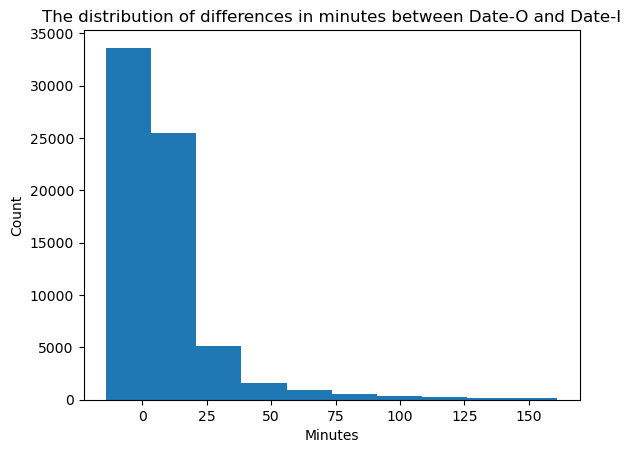

In [145]:
## 3.1.9 The distribution of min_diff
plt.hist(df.min_diff, bins=10)
plt.title('The distribution of differences in minutes between Date-O and Date-I')
plt.ylabel('Count')
plt.xlabel('Minutes')
plt.show()

Hist.1. The distribution of min_diff

From this table, we can check how delay minutes are distributed. And we can see most of the flights were delayed within 15 mins. We'll check how many percentage of the data has been delayed more than 15 mins in the later part.

Overall, from data exploration, there are 4 things required to be noteworthy: (1) the day may effect delayed rate directly based on some uncontrol factors(e.g weather) which not include in datasets, (2) the airline code may be inconsistent between operation and program, (3) the airport code may be inconsistent between operation and program, (4) Most of flights are not delayed more than 15 mins.

### 3.2 Relationship between delay rate and other variables

In [127]:
## 3.2.0 The overall delay rate
print('The overall average delay rate is {}'.format(df['delay_15'].sum()/df.shape[0]))

The overall average delay rate is 0.18493974137172683


In [146]:
## 3.2.1 Behavior of Delay rate over destinations
### 3.2.1.1 Show the distribution of Delay rate over different destinations
dest_df = df.groupby([df['Des-I']])[['Vlo-I']].count().reset_index().rename(columns={'Des-I':'Destination Airport', 'Vlo-I':'Flights'})
delay_df = df.groupby([df['Des-I']])[['delay_15']].sum().reset_index().rename(columns={'Des-I':'Destination Airport', 'delay_15':'Delayed Flights'})
dest_df = dest_df.join(delay_df.set_index('Destination Airport'), how='inner', on='Destination Airport')
dest_df['Delayed Ratio'] = dest_df['Delayed Flights']/dest_df['Flights']
dest_df = dest_df[['Destination Airport', 'Delayed Ratio']].sort_values(by='Delayed Ratio', ascending=False).reset_index().drop(columns=['index'])
print(tabulate(dest_df, headers = 'keys', tablefmt = 'psql'))

+----+-----------------------+-----------------+
|    | Destination Airport   |   Delayed Ratio |
|----+-----------------------+-----------------|
|  0 | EGYP                  |       1         |
|  1 | SLCB                  |       1         |
|  2 | SEQU                  |       1         |
|  3 | SEQM                  |       1         |
|  4 | SAWH                  |       0.666667  |
|  5 | YSSY                  |       0.579487  |
|  6 | YMML                  |       0.552632  |
|  7 | SAZS                  |       0.5       |
|  8 | SAAR                  |       0.397059  |
|  9 | NZAA                  |       0.373961  |
| 10 | MDPC                  |       0.333333  |
| 11 | CYYZ                  |       0.314488  |
| 12 | SACO                  |       0.301075  |
| 13 | SGAS                  |       0.284483  |
| 14 | SBGL                  |       0.282427  |
| 15 | SAME                  |       0.272615  |
| 16 | SABE                  |       0.268261  |
| 17 | KMCO         

Table.9. The distribution of average delay rate by Programmed Airport code

From this table, we can check how the day of the average delay rate by Programmed Airport code is distributed. There are some dest airports that have zero delays while some other airports their flights are all delayed.

In [129]:
### 3.2.1.2 Show the statistics of Delay rate over different destinations
dest_df['Delayed Ratio'].describe()

count    64.000000
mean      0.253194
std       0.234241
min       0.000000
25%       0.135833
50%       0.190316
75%       0.269350
max       1.000000
Name: Delayed Ratio, dtype: float64

As we can see from the describe summary, the standard deviation is really high in this case.

In [130]:
## 3.2.2 Behavior of Delay rate over airlines
### 3.2.2.1 Show the distribution of Delay rate over different airlines
airline_df = df.groupby([df['Emp-I']])[['Vlo-I']].count().reset_index().rename(columns={'Emp-I':'Airline', 'Vlo-I':'Flights'})
delay_df = df.groupby([df['Emp-I']])[['delay_15']].sum().reset_index().rename(columns={'Emp-I':'Airline', 'delay_15':'Delayed Flights'})
airline_df = airline_df.join(delay_df.set_index('Airline'), how='inner', on='Airline')
airline_df['Delayed Ratio'] = airline_df['Delayed Flights']/airline_df['Flights']
airline_df = airline_df[['Airline', 'Delayed Ratio']].sort_values(by='Delayed Ratio', ascending=False).reset_index().drop(columns=['index'])
print(tabulate(airline_df, headers = 'keys', tablefmt = 'psql'))


+----+-----------+-----------------+
|    | Airline   |   Delayed Ratio |
|----+-----------+-----------------|
|  0 | LNE       |       1         |
|  1 | DSM       |       1         |
|  2 | LXP       |       0.777778  |
|  3 | PUE       |       0.612245  |
|  4 | QFU       |       0.579487  |
|  5 | LPE       |       0.5       |
|  6 | ACA       |       0.456637  |
|  7 | LAW       |       0.407878  |
|  8 | JMR       |       0.39      |
|  9 | GLO       |       0.356079  |
| 10 | LAP       |       0.282407  |
| 11 | AVA       |       0.265625  |
| 12 | TAM       |       0.255822  |
| 13 | ARG       |       0.240123  |
| 14 | AUT       |       0.202703  |
| 15 | JAT       |       0.178995  |
| 16 | SKU       |       0.177647  |
| 17 | LAN       |       0.171572  |
| 18 | ONE       |       0.154122  |
| 19 | BAW       |       0.141463  |
| 20 | LRC       |       0.119565  |
| 21 | AZA       |       0.111969  |
| 22 | IBE       |       0.0994475 |
| 23 | AFR       |       0.0837989 |
|

Table.10. The distribution of average delay rate by Programmed Airline code

From this table, we can check how the day of the average delay rate by Programmed Airline code is distributed. There are some Airline that have really low delay rate while some other Airline have really high delay rate.

In [131]:
### 3.2.2.2 Show the statistics of Delay rate over different Airlines
airline_df['Delayed Ratio'].describe()

count    30.000000
mean      0.297233
std       0.268218
min       0.028490
25%       0.102578
50%       0.190849
75%       0.403409
max       1.000000
Name: Delayed Ratio, dtype: float64

As we can see from the describe summary, the standard deviation is really high in this case.

In [132]:
As we can see from the describe summary, the standard deviation is really high in this case.## 3.2.3 Behavior of Delay rate over month of the year
### 3.2.3.1 Show the distribution of Delay rate over month of the year
month_df = df.groupby([df['MES']])[['Vlo-I']].count().reset_index().rename(columns={'MES':'Month', 'Vlo-I':'Flights'})
delay_df = df.groupby([df['MES']])[['delay_15']].sum().reset_index().rename(columns={'MES':'Month', 'delay_15':'Delayed Flights'})
month_df = month_df.join(delay_df.set_index('Month'), how='inner', on='Month')
month_df['Delayed Ratio'] = month_df['Delayed Flights']/month_df['Flights']
month_df = month_df[['Month', 'Delayed Ratio']].sort_values(by='Delayed Ratio', ascending=False).reset_index().drop(columns=['index'])
print(tabulate(month_df, headers = 'keys', tablefmt = 'psql'))

+----+---------+-----------------+
|    |   Month |   Delayed Ratio |
|----+---------+-----------------|
|  0 |       7 |        0.293391 |
|  1 |      12 |        0.254091 |
|  2 |      10 |        0.225962 |
|  3 |      11 |        0.197204 |
|  4 |       8 |        0.173398 |
|  5 |       9 |        0.172371 |
|  6 |       6 |        0.17105  |
|  7 |       1 |        0.160118 |
|  8 |       5 |        0.157824 |
|  9 |       2 |        0.151591 |
| 10 |       4 |        0.116534 |
| 11 |       3 |        0.115104 |
+----+---------+-----------------+


Table.11. The distribution of average delay rate by month

From this table, we can say the 7th & 12th Month is obviously much higher than other months when 4th & 3rd months have lower average delay than other months.

In [133]:
### 3.2.3.2 Show the statistics of Delay rate over months of the year
month_df['Delayed Ratio'].describe()

count    12.000000
mean      0.182386
std       0.052917
min       0.115104
25%       0.156266
50%       0.171710
75%       0.204393
max       0.293391
Name: Delayed Ratio, dtype: float64

As we can see from the describe summary, the standard deviation is relatively low in this case. So we could focus on some special months instead of including all months in model.

In [134]:
As we can see from the describe summary, the standard deviation is really high in this case.## 3.2.4 Behavior of Delay rate over day of the week
### 3.2.4.1 Show the distribution of Delay rate over day of the week
day_df = df.groupby([df['DIANOM']])[['Vlo-I']].count().reset_index().rename(columns={'DIANOM':'Day of the week', 'Vlo-I':'Flights'})
delay_df = df.groupby([df['DIANOM']])[['delay_15']].sum().reset_index().rename(columns={'DIANOM':'Day of the week', 'delay_15':'Delayed Flights'})
day_df = day_df.join(delay_df.set_index('Day of the week'), how="inner", on='Day of the week')
day_df['Delayed Ratio'] = day_df['Delayed Flights']/day_df['Flights']
day_df = day_df[['Day of the week', 'Delayed Ratio']].sort_values(by='Delayed Ratio', ascending=False).reset_index().drop(columns=['index'])
print(tabulate(day_df, headers = 'keys', tablefmt = 'psql'))


+----+-------------------+-----------------+
|    | Day of the week   |   Delayed Ratio |
|----+-------------------+-----------------|
|  0 | Viernes           |        0.222017 |
|  1 | Lunes             |        0.202152 |
|  2 | Jueves            |        0.199493 |
|  3 | Miercoles         |        0.17085  |
|  4 | Martes            |        0.169116 |
|  5 | Sabado            |        0.163194 |
|  6 | Domingo           |        0.161086 |
+----+-------------------+-----------------+


Table.12. The distribution of average delay rate by the day of the week

From this table, we can say the Friday is obviously much higher than other days.

In [135]:
### 3.2.4.2 Show the statistics of Delay rate over day of the week
day_df['Delayed Ratio'].describe()

count    7.000000
mean     0.183987
std      0.023690
min      0.161086
25%      0.166155
50%      0.170850
75%      0.200822
max      0.222017
Name: Delayed Ratio, dtype: float64

As we can see from the describe summary, the standard deviation is relatively low in this case.

In [136]:
As we can see from the describe summary, the standard deviation is relatively low in this case.## 3.2.5 Behavior of Delay rate over season
### 3.2.5.1 Show the distribution of Delay rate over season
season_df = df.groupby([df['high_season']])[['Vlo-I']].count().reset_index().rename(columns={'Vlo-I':'Flights'})
delay_df = df.groupby([df['high_season']])[['delay_15']].sum().reset_index().rename(columns={'delay_15':'Delayed Flights'})
season_df = season_df.join(delay_df.set_index('high_season'), how='inner', on='high_season')
season_df['Delayed Ratio'] = season_df['Delayed Flights']/season_df['Flights']
season_df = season_df[['high_season', 'Delayed Ratio']].sort_values(by='Delayed Ratio', ascending=False).reset_index().drop(columns=['index'])
print(tabulate(season_df, headers = 'keys', tablefmt = 'psql'))


+----+---------------+-----------------+
|    |   high_season |   Delayed Ratio |
|----+---------------+-----------------|
|  0 |             0 |        0.18758  |
|  1 |             1 |        0.179444 |
+----+---------------+-----------------+


Table.13. The distribution of average delay rate by season

From this table, we can say the high season has a delay rate which is slightly lower than the regular season.

In [137]:
Table.11. The distribution of average delay rate by month

From this table, we can say the 7th Month is obviously much higher than other months when 4th & 3rd months have lower average delay than other months.## 3.2.6 Behavior of Delay rate over type of flight
### 3.2.6.1 Show the distribution of Delay rate over type of flight
type_df = df.groupby([df['TIPOVUELO']])[['Vlo-I']].count().reset_index().rename(columns={'TIPOVUELO':'Type of Flight', 'Vlo-I':'Flights'})
delay_df = df.groupby([df['TIPOVUELO']])[['delay_15']].sum().reset_index().rename(columns={'TIPOVUELO':'Type of Flight', 'delay_15':'Delayed Flights'})
type_df = type_df.join(delay_df.set_index('Type of Flight'), how="inner", on='Type of Flight')
type_df['Delayed Ratio'] = type_df['Delayed Flights']/type_df['Flights']
type_df = type_df[['Type of Flight', "Delayed Ratio"]].sort_values(by="Delayed Ratio", ascending=False).reset_index().drop(columns=['index'])
print(tabulate(type_df, headers = 'keys', tablefmt = 'psql'))


+----+------------------+-----------------+
|    | Type of Flight   |   Delayed Ratio |
|----+------------------+-----------------|
|  0 | I                |        0.225608 |
|  1 | N                |        0.150571 |
+----+------------------+-----------------+


Table.14. The distribution of average delay rate by Type of Flight

From this table, we can say the national flight has a delay rate which is lower than international flight which make significant differences.

From the above analysis, we can consider the effects of (1) Destination Airport, (2) Airline Code, (3) Type of flight, (4) Some special months of flight and (5) whether it's Friday on the likelihood of delay. Besides that, we can also include the average delay rate of the day in the model.

## 4.0 Models

Before training the model, we need to think carefully about how to include those five kinds of information in the model. For (3), (4) and (5), we can use dummies directly, but for (1) and (2) I used an uncommon transformation. Ideally, I designed to include the average delay ratio of each destination airport and airline before the current date. I have tried to use groupby date and dest airport/airline to calculate the number of delayed flights and the total number of flights on the day, and then use the method of adding all previous dates to calculate the total number of previous flights and the number of delayed flights and get the average of delayed ratio before the day of the flight. However, an error has been reported, and I have no time to debug it. So I only use the average of delay rate overall dataset directly as `average_airline_delay` and `average_dest_delay` - note, this is INCORRECT, but just a substitute to represent my actual idea. The same logic is also applied on `average_24h_delay`. Ideally, this should be the delay rate of the last 24 hours of the flight.

Besides of these factors, we also introduce `is_switch_airline` and `is_switch_airport` to indicate whether the flight has different airline/dest code. You can see more details in README.

### 4.1 Training and Validation Models

In [179]:
## 4.1.1 New features based on 3.0
model_df = df.copy()

### The average delay rate in that day
model_df['Date-I'] = df['Fecha-I'].dt.date
model_df = pd.merge(model_df, date_df, how='inner', left_on=['Date-I'], 
                    right_on=['Date']).rename(columns={'Delayed Ratio':'average_24h_delay'})
model_df['average_24h_delay'] = np.where(model_df['average_24h_delay']==1, 0.99, model_df['average_24h_delay'])
model_df = model_df.drop(columns=['Date-I'])

### The average delay rate of the airline
model_df = pd.merge(model_df, airline_df, how='inner', left_on=['Emp-I'], 
                    right_on=['Airline']).rename(columns={'Delayed Ratio':'avg_airline_delay'})
model_df['avg_airline_delay'] = np.where(model_df['avg_airline_delay']==1, 0.99, model_df['avg_airline_delay'])
### The average delay rate of the destination
model_df = pd.merge(model_df, dest_df, how='inner', left_on=['Des-I'], 
                    right_on=['Destination Airport']).rename(columns={'Delayed Ratio':'avg_dest_delay'})
model_df['avg_dest_delay'] = np.where(model_df['avg_dest_delay']==1, 0.99, model_df['avg_dest_delay'])

### The binary variable to indicate whether the flight switched Airport
model_df['is_switch_airport'] = np.where(model_df['Des-O'] != model_df['Des-I'], 1, 0)

### The binary variable to indicate whether the flight switched Airline or flight
model_df['is_switch_airline'] = np.where((model_df['Emp-O'] != model_df['Emp-I'])|(model_df['Vlo-I'] != model_df['Vlo-O']), 1, 0)
### The binary variable to indicate whether the flight is in high delayed months.
model_df['is_high_delay_month'] = np.where(model_df['MES'].isin([7, 12]), 1, 0)
### The binary variable to indicate whether the flight is in low delayed months.
model_df['is_low_delay_month'] = np.where(model_df['MES'].isin([3, 4]), 1, 0)
### The binary variable to indicate whether the flight is in Friday
model_df['is_Friday'] = np.where(model_df['DIANOM']=='Viernes', 1, 0)

### Make Type of Flight Dummies
df_flight = pd.get_dummies(model_df['TIPOVUELO'], prefix='type', drop_first=True)
model_df = pd.concat((model_df, df_flight), axis=1)

In [180]:
### 4.1.2 Split Training, Validation and testing
X = model_df[['high_season', 'is_switch_airport', 'is_switch_airline','average_24h_delay', 'is_high_delay_month',
              'is_low_delay_month','is_Friday', 'avg_airline_delay','avg_dest_delay'] +list(df_flight.columns)]
y = model_df['delay_15']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

## 4.1.3 Model1: Logit
### 4.1.3.1 Train the model
max_roc = 0
max_precision = 0
best_feat = []
for k in range(5,11):
    selector = SelectKBest(f_classif, k=k)
    selector.fit(X_train, y_train)
    cols = selector.get_support(indices=True)
    print(X_train.iloc[:,cols].columns)
    log_reg = sm.Logit(y_train, sm.add_constant(X_train.iloc[:,cols])).fit()
    y_pred = log_reg.predict(sm.add_constant(X_val.iloc[:,cols]))
    precision = average_precision_score(y_val, y_pred)
    roc = roc_auc_score(y_val, y_pred)
    if precision + roc > max_roc + max_precision:
        max_precision = precision 
        max_roc = roc
        best_model = cols

### 4.1.3.2 Best Performance on Validation Set
print('ROC AUC: {}, Average Precision Score: {}'.format(max_roc, max_precision))
logit_features = X_train.iloc[:,cols].columns.tolist()
print('The best feature group is {} for logistic Regression'.format(logit_features))

Index(['average_24h_delay', 'is_high_delay_month', 'avg_airline_delay',
       'avg_dest_delay', 'type_N'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.437335
         Iterations 6
Index(['average_24h_delay', 'is_high_delay_month', 'is_low_delay_month',
       'avg_airline_delay', 'avg_dest_delay', 'type_N'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.437183
         Iterations 6
Index(['average_24h_delay', 'is_high_delay_month', 'is_low_delay_month',
       'is_Friday', 'avg_airline_delay', 'avg_dest_delay', 'type_N'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.437181
         Iterations 6
Index(['high_season', 'average_24h_delay', 'is_high_delay_month',
       'is_low_delay_month', 'is_Friday', 'avg_airline_delay',
       'avg_dest_delay', 'type_N'],
      dtype='object')
Optimization terminated successfully.
         Current funct

In [181]:
### 4.1.3.3 The summary of Logistics Regression
log_reg = sm.Logit(y_train, sm.add_constant(X_train[logit_features])).fit()
display(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.437153
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               delay_15   No. Observations:                43651
Model:                          Logit   Df Residuals:                    43640
Method:                           MLE   Df Model:                           10
Date:                Tue, 20 Dec 2022   Pseudo R-squ.:                 0.08823
Time:                        21:25:12   Log-Likelihood:                -19082.
converged:                       True   LL-Null:                       -20929.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -4.0729      0.078    -52.549      0.000      -4.225      -3.921
high_season             0.0076      0.029      0.266      0.790      -0.048       0.064
is_switch_airport      -0.0040      0.651     -0.006      0.995      -1.281       1.272
is_switch_airline       0.0476      0.031      1.537      0.124      -0.013       0.108
average_24h_delay       5.8602      0.156     37.563      0.000       5.554       6.166
is_high_delay_month    -0.0231      0.035     -0.653      0.514      -0.093       0.046
is_low_delay_month     -0.1566      0.045     -3.463      0.001      -0.245      -0.068
is_Friday               0.0134      0.035      0.380      0.704      -0.056       0.082
avg_airline_delay       3.8015      0.202     18.861      0.000       3.406       4.197
avg_dest_delay          4.0085      0.297     13.477      0.000       3.426       4.591
type_N                 -0.1303      0.037     -3.527      0.000      -0.203      -0.058
=======================================================================================
"""

Summary.1. The summary of Best logistic Regression which we fit

In [182]:
## 4.1.4 Model2: Decision Tree
### 4.1.4.1 Split Training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

### 4.1.4.2 Train the model
max_roc = 0 
max_precision = 0
best_k = None
for k in range(4,11):
    sqft_tree = tree.DecisionTreeRegressor(max_depth=k).fit(X_train,y_train)
    y_pred = sqft_tree.predict(X_val)
    precision = average_precision_score(y_val, y_pred)
    roc = roc_auc_score(y_val, y_pred)
    if precision + roc > max_roc + max_precision:
        best_k = k
        max_roc = roc
        max_precision = precision
### 4.1.4.3 Best Performance on Validation Set
print('ROC AUC: {}, Average Precision Score: {}'.format(max_roc, max_precision))
print('The best max depth is {} for logistic Regression'.format(best_k))

ROC AUC: 0.7033200031155817, Average Precision Score: 0.3476280212875111
The best max depth is 6 for logistic Regression


In [183]:
## 4.1.5 Model3: XGBoost
### 4.1.5.1 Train the model
max_roc = 0 
max_precision = 0
best_lr = None
best_depth = None
best_alpha = None
best_n_estimator = None
best_min_weight = None
for learning_rate in [0.1, 0.2, 0.5, 1]:
    for max_depth in [5, 10, 20]:
        for alpha in [5, 10, 15]:
            for n_estimators in [5, 12, 20]:
                for min_child_weight in [2, 5, 8, 10]:
                    xg_reg = xgb.XGBRegressor(objective ='binary:logistic', min_child_weight = min_child_weight, learning_rate = learning_rate,
                                    max_depth = max_depth, alpha = alpha, n_estimators = n_estimators)
                    xg_reg.fit(X_train,y_train)
                    preds = xg_reg.predict(X_val)
                    precision = average_precision_score(y_val, preds)
                    roc = roc_auc_score(y_val, preds)
                    if precision + roc > max_roc + max_precision:
                        best_lr = learning_rate
                        best_depth = max_depth
                        best_alpha = alpha
                        best_n_estimator = n_estimators
                        best_min_weight = min_child_weight
                        max_precision = precision 
                        max_roc = roc

### 4.1.5.2 Best Performance on Validation Set
print('ROC AUC: {}, Average Precision Score: {}'.format(max_roc, max_precision))
print('The best hyperparameter for XGBoost:\nlearning_rate = {}\nmax_depth = {}\nalpha = {}\nn_estimator={}\nmin_child_weight={}\n'.format(best_lr, best_depth, best_alpha, best_n_estimator, best_min_weight))

ROC AUC: 0.7183835481841697, Average Precision Score: 0.3856965938505744
The best hyperparameter for XGBoost:
learning_rate = 0.5
max_depth = 5
alpha = 5
n_estimator=20
min_child_weight=10



### 4.2 Performance Evaluation and Discussion

In [184]:
## 4.2.1 Run the models over Test & Training dataset
### 4.2.1.1 Model1: Logistic Regression
y_pred = log_reg.predict(sm.add_constant(X_test[logit_features]))
precision = average_precision_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)
y_pred = log_reg.predict(sm.add_constant(X_train[logit_features]))
tr_precision = average_precision_score(y_train, y_pred)
tr_roc = roc_auc_score(y_train, y_pred)
print('Logistic Regression: \nTest ROC-AUC: {}, Test Average Precision Score: {}\nTrain ROC-AUC: {}, Train Average Precision Score: {}'.format(roc, precision, tr_roc, tr_precision))

### 4.2.1.2 Model2: Decision Tree
sqft_tree = tree.DecisionTreeRegressor(max_depth=best_k).fit(X_train,y_train)
y_pred = sqft_tree.predict(X_test)
precision = average_precision_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)
y_pred = sqft_tree.predict(X_train)
tr_precision = average_precision_score(y_train, y_pred)
tr_roc = roc_auc_score(y_train, y_pred)
print('Decision Tree: \nTest ROC-AUC: {}, Test Average Precision Score: {}\nTrain ROC-AUC: {}, Train Average Precision Score: {}'.format(roc, precision, tr_roc, tr_precision))

### 4.2.1.3 Model3: XGBoost
xg_reg = xgb.XGBRegressor(objective ='binary:logistic', min_child_weight = best_min_weight, learning_rate = best_lr,
                                    max_depth = best_depth, alpha = best_alpha, n_estimators = best_n_estimator).fit(X_train,y_train)
preds = xg_reg.predict(X_test)
precision = average_precision_score(y_test, preds)
roc = roc_auc_score(y_test, preds)
y_pred = xg_reg.predict(X_train)
tr_precision = average_precision_score(y_train, y_pred)
tr_roc = roc_auc_score(y_train, y_pred)
print('XGBoost: \nTest ROC-AUC: {}, Test Average Precision Score: {}\nTrain ROC-AUC: {}, Train Average Precision Score: {}'.format(roc, precision, tr_roc, tr_precision))

Logistic Regression: 
Test ROC-AUC: 0.7156063689591552, Test Average Precision Score: 0.3672942439216217
Train ROC-AUC: 0.712758338729576, Train Average Precision Score: 0.3636953627179078
Decision Tree: 
Test ROC-AUC: 0.7097804750677886, Test Average Precision Score: 0.3572454188383003
Train ROC-AUC: 0.7176082465490411, Train Average Precision Score: 0.3718767190316226
XGBoost: 
Test ROC-AUC: 0.7204307840753978, Test Average Precision Score: 0.3830219038499825
Train ROC-AUC: 0.7362601177500746, Train Average Precision Score: 0.40782690073877154


Summary.2. The summary of performance on all three models
Based on Summary.2, all models performed well on ROC-AUC but really bad on average precision score since the positive rate of target(which is delay_15) is really low thus we determine ROC-AUC as our performance metric. In this case, the XGBoost did best over three models. Then let's check which feature is the most important.

In [98]:
feature = X_train.columns.tolist()[np.argmax(xg_reg.feature_importances_)]
print('The most influential in the prediction task is {} by feature_importances_ check in XGBoost model'.format(feature))

The most influential in the prediction task is avg_date_delay by feature_importances_ check in XGBoost model


From the trained models, we can just say it's really important for average delay rate in the day. It does make sense since delays longer than 15 minutes tend to occur in large stretches and are caused by weather or special events. Although we do not have data on weather and special events, we can indirectly deduce the possibility of delay of the current flight through the average delay ratio within 24 hours. In addition, the usual performance of airlines and destination airports should also affect this probability. As mentioned at the beginning, we ideally should get the rate from the dataset by the previous day instead of all.

## 5.0 Conclusion and Next Step
The goal of this project is to predict the probability of delay of the flights that land or take off from the airport of Santiago de Chile (SCL). For that, we have a dataset using public and real data where each row corresponds to a flight that landed or took off from SCL in 2017.

In conclusion, even if the current training model performs well in general, we still require updating some features and introducing more new features. So here are improvements which we can make in future:

(1) Update `avg_airline_delay`, `avg_airport_delay` and `avg_24h_delay` from average over all datasets -> average over all previous date/24hours

(2) Consider doing more data exploration(e.g. Correlation between different variables) and include the conclusion from the exploration into our new version of data engineering.

(3) More machine learning models and handling methods for the imbalanced target.